In [1]:
from qiskit import *
import numpy as np

In [2]:
def amplitudePartialSum(qc, M):
    n = qc.num_qubits

    if (M & (M - 1)) == 0:  # M is power of 2
        r = int(np.log2(M))
        for i in range(r):
            qc.h(i)
        return qc

    # M is not a power of 2 

    # compute l[0],l[1],...,l[k]
    # an ordered sequence of numbers representing 
    # the locations of 1 in the reverse binary representation of M
    l = [] 
    for pos in range(n):
        if (M >> pos) & 1:
            l.append(pos)
    k = len(l) - 1   

    Mm = M - 2**l[k]
    for m in range(k-1, 0, -1):
        # controlled Hadamard (H) gate on |qi⟩ for i=l[m+1]−1, l[m+1]−2,…, l[m]+1, l[m],
        # conditioned on ql[m+1] being equal to 0.
        qc.x(l[m+1])
        for i in range(l[m],l[m+1]):
            qc.ch(l[m+1], i)
        qc.x(l[m+1])

        Mm = Mm - 2**l[m]

        # controlled RY(𝜃m) gate, with 𝜃m=2*arccos(sqrt((2**l[m])/(M-Mm))), 
        # on ql[m+1] conditioned on ql[m] being 0
        theta_m = 2*np.arccos(np.sqrt((2**l[m])/(M-Mm)))
        qc.x(l[m])
        qc.cry(theta_m, l[m], l[m+1])
        qc.x(l[m])

    # controlled Hadamard (H) gate on |qi⟩ for i=l[1]−1, l[1]−2,…, l[0]+1, l[0],
    # conditioned on ql[1] being equal to 0.
    qc.x(l[1])
    for i in range(l[0],l[1]):
        qc.ch(l[1], i)
    qc.x(l[1])

    # RY(𝜃0) gate, with 𝜃0=2*arccos(sqrt((2**l[m])/(M-Mm))), on ql[1] 
    theta_m = 2*np.arccos(np.sqrt((Mm)/(M)))
    qc.ry(theta_m, l[1])


    # if M is even r, then apply Hadamard gates on the rightmost l[0] qubits
    if(l[0]>0):
        for i in range(0,l[0]):
            qc.h(i)

    # X gate on qi for i= l[1], l[2],…, l[k]
    for i in range(1, k+1):
        qc.x(l[i])

    return qc

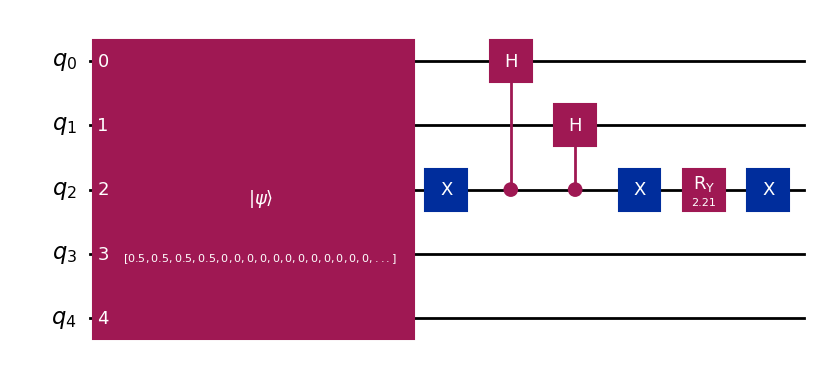

In [3]:
n = 5
N=2**n
qc = QuantumCircuit(n)
f = np.array([1, 1, 1, 1] + [0]*(N-4), dtype=complex)
scale=np.linalg.norm(f)
f1 = f / scale
qc.initialize(f1, list(range(n)))

M = 5

amplitudePartialSum(qc, M)


qc.draw(output='mpl')


In [4]:
from qiskit.quantum_info import Statevector

sv = Statevector.from_instruction(qc)
amps = sv.data

amp_0 = amps[0]

print("Amplitude of |0> =", amp_0)
expected = (1/np.sqrt(M)) * np.sum(f1[:M])
print("Expected =", expected)
print("Difference =", abs(amp_0 - expected))

print("Sm =", np.sqrt(M)*amp_0*scale )
print("Expected =", np.sum(f[:M]))
print("Difference =", abs(np.sqrt(M)*amp_0*scale - np.sum(f[:M])))




Amplitude of |0> = (0.8944271909999156+0j)
Expected = (0.8944271909999159+0j)
Difference = 2.220446049250313e-16
Sm = (3.999999999999999+0j)
Expected = (4+0j)
Difference = 8.881784197001252e-16


In [5]:
def weightedAmplitudePartialSum(qc, M, b):
    n = qc.num_qubits

    # compute l[0],l[1],...,l[k]
    # an ordered sequence of numbers representing 
    # the locations of 1 in the reverse binary representation of M
    l = [] 
    for pos in range(n):
        if (M >> pos) & 1:
            l.append(pos)
    k = len(l) - 1   

    Mm = M - 2**l[k]

    for m in range(k-1, 0, -1):
        # controlled Hadamard (H) gate on |qi⟩ for i=l[m+1]−1, l[m+1]−2,…, l[m]+1, l[m],
        # conditioned on ql[m+1] being equal to 0.
        qc.x(l[m+1])
        for i in range(l[m],l[m+1]):
            qc.ch(l[m+1], i)
        qc.x(l[m+1])

        Mm = Mm - 2**l[m]

        # controlled RY(𝜃m) gate, with 𝜃m=2*arccos(b[m]), 
        # on ql[m+1] conditioned on ql[m] being 0
        theta_m = 2*np.arccos(m[m])
        qc.x(l[m])
        qc.cry(theta_m, l[m], l[m+1])
        qc.x(l[m])

    # controlled Hadamard (H) gate on |qi⟩ for i=l[1]−1, l[1]−2,…, l[0]+1, l[0],
    # conditioned on ql[1] being equal to 0.
    qc.x(l[1])
    for i in range(l[0],l[1]):
        qc.ch(l[1], i)
    qc.x(l[1])

    # RY(𝜃0) gate, with 𝜃0=2*arccos(b[0]), on ql[1] 
    theta_m = 2*np.arccos(b[0])
    qc.ry(theta_m, l[1])


    # if M is even r, then apply Hadamard gates on the rightmost l[0] qubits
    if(l[0]>0):
        for i in range(0,l[0]):
            qc.h(i)

    # X gate on qi for i= l[1], l[2],…, l[k]
    for i in range(1, k+1):
        qc.x(l[i])

    return qc

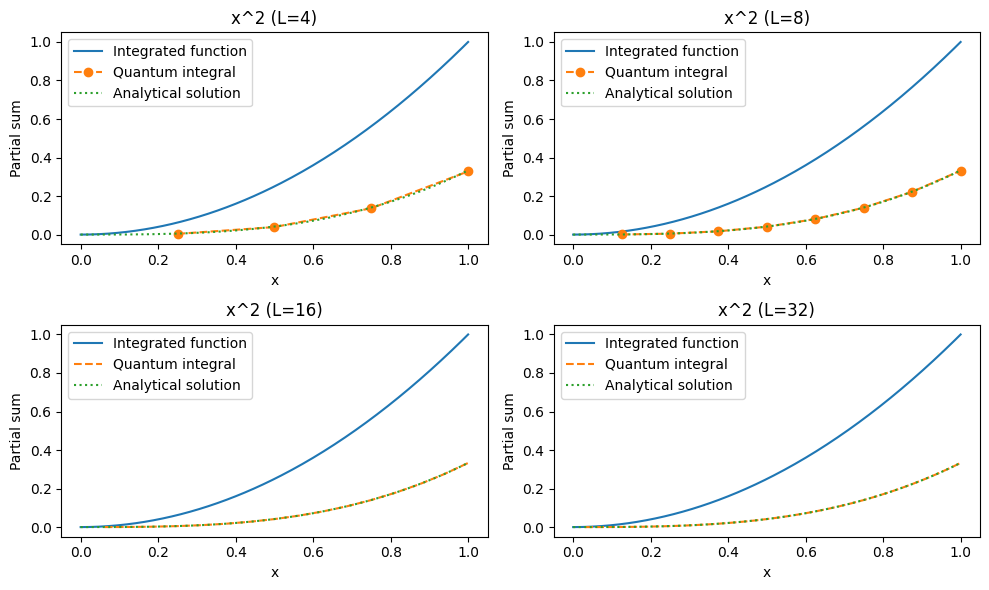

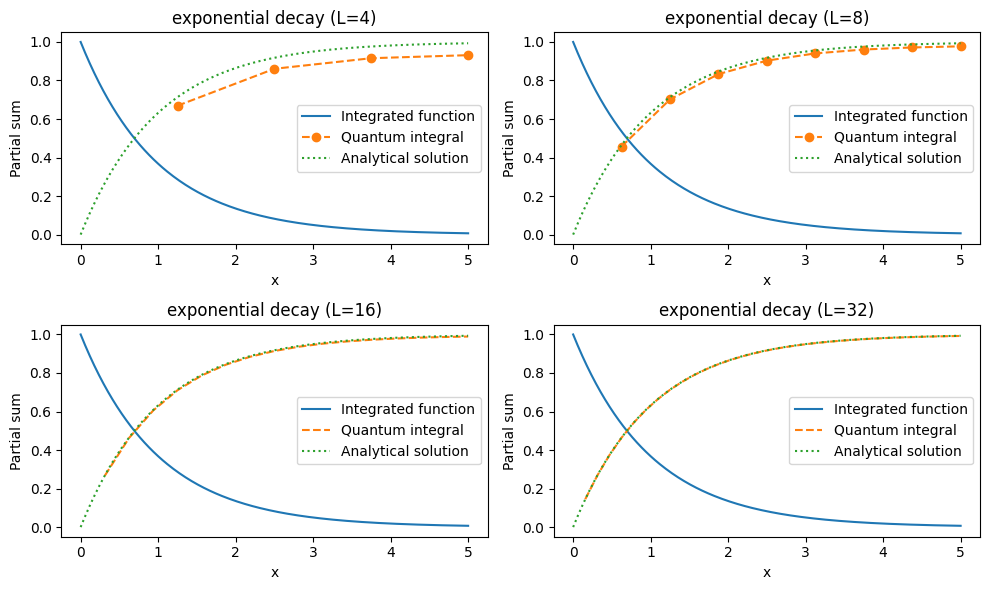

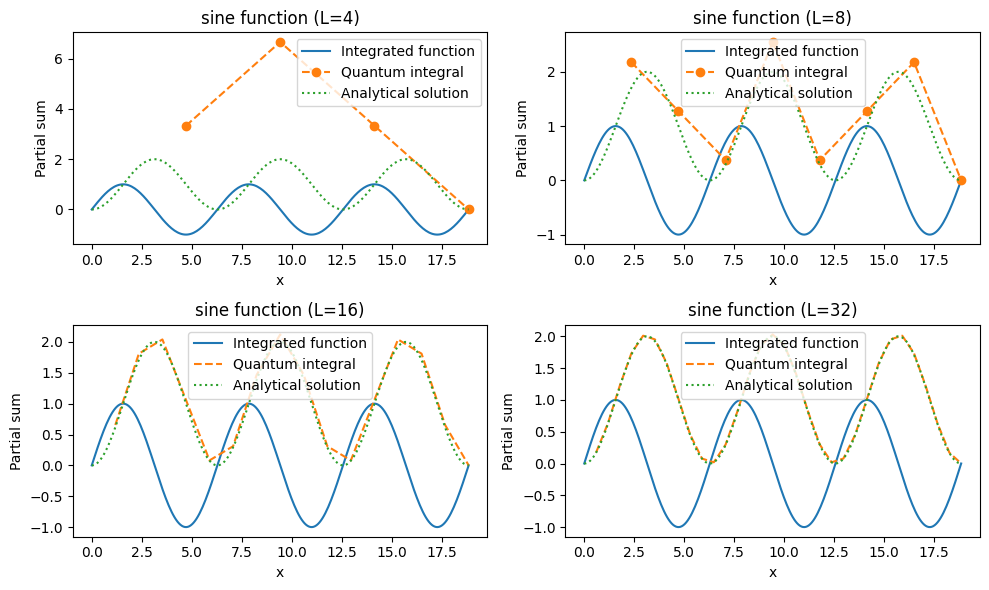

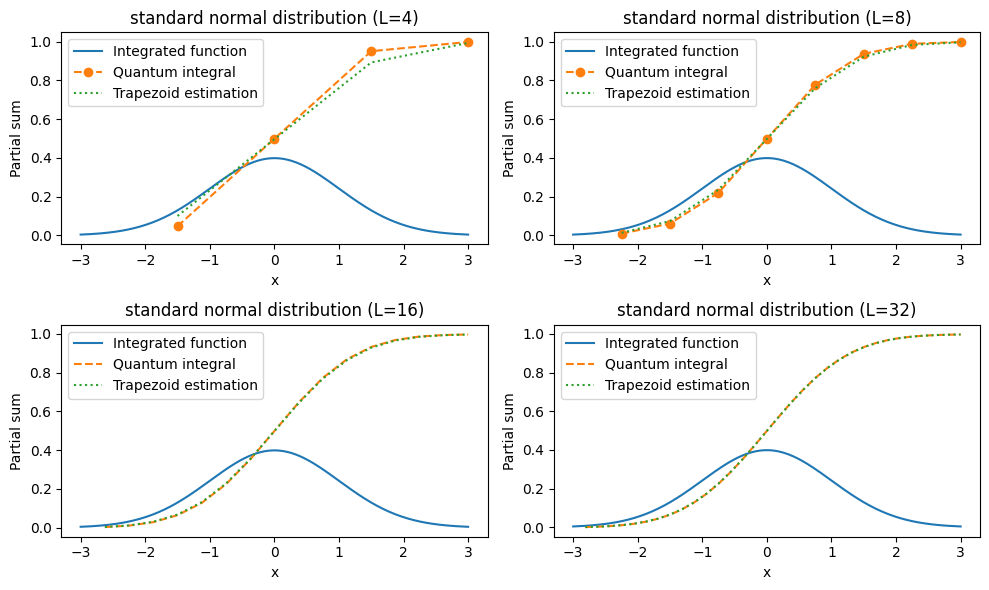

In [17]:
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import numpy as np
import math

def quantum_partial_sum_estimate(f, M):
    # choose minimal qubits to hold f
    n = int(np.ceil(np.log2(len(f))))
    N = 2**n
    if M > N:
        raise ValueError(f"M={M} is larger than available amplitude vector length N={N}. Increase sampling length L.")

    fpad = np.zeros(N, dtype=complex)
    fpad[:len(f)] = f
    scale = np.linalg.norm(fpad)
    if scale == 0:
        return 0.0
    f1 = fpad / scale
    qc = QuantumCircuit(n)
    qc.initialize(f1, list(range(n)))
    amplitudePartialSum(qc, M)
    sv = Statevector.from_instruction(qc)
    amp0 = sv.data[0]
    Sm = np.sqrt(M) * amp0 * scale
    return Sm.real

def sample(f, a, b, L):
    """Sample function f on k equidistant points (mid-points of equally sized intervals) in (a,b)."""
    half_of_interval = (b-a) / (2*L)
    x = np.linspace(a + half_of_interval, b-half_of_interval, L)
    return f(x)

def plot_integrals_by_sample_size(name, f, a, b, j, analytical_solution = None):
    Ls = [4, 8, 16, 32]
    fig = plt.figure(figsize=(10,6))
    for (i, L) in enumerate(Ls, 1):
        fvals = sample(f, a, b, L)
        xs = np.linspace(a, b, L+1)[1:] # end points of intervals

        # plot original function
        plt.subplot(2, 2, i)
        plt.plot(np.linspace(a, b, 256), f(np.linspace(a, b, 256)), label='Integrated function')

        # plot our approximation
        Sq = np.array([quantum_partial_sum_estimate(fvals, i) for i in range(1, L+1)]) * (b-a)/L
        marker = 'o' if L <= 8 else None
        plt.plot(xs, Sq, label='Quantum integral', linestyle='--', marker=marker)

        # plot "Classical" approximation
        if (analytical_solution is not None):
            plt.plot(np.linspace(a, b, 256), analytical_solution(np.linspace(a, b, 256)) - analytical_solution(a), label='Analytical solution', linestyle=':')
        else:
            # Trapezoidal rule cumulative integral at endpoints x1..xL
            node_x = np.linspace(a, b, L+1)
            node_vals = f(node_x)
            h = (b - a) / L
            cumsum = np.cumsum(node_vals)
            Sr = h * (cumsum[1:] - 0.5 * (node_vals[0] + node_vals[1:]))
            plt.plot(xs, Sr, label='Trapezoid estimation', linestyle=':')

        # Label plot
        plt.xlabel('x')
        plt.ylabel('Partial sum')
        plt.title(f'{name} (L={L})')
        plt.legend()

    # show plot
    plt.tight_layout()
    fig.savefig(f'integration-{j}')
    plt.show()

x2 = lambda x: x * x
plot_integrals_by_sample_size("x^2", x2, 0, 1, 0, analytical_solution = lambda x: np.pow(x, 3) / 3 )

exp = lambda x: np.exp(-x)
plot_integrals_by_sample_size("exponential decay", exp, 0, 5, 1, analytical_solution = lambda x: 1 - np.exp(-x) )

sine = lambda x: np.sin(x)
plot_integrals_by_sample_size("sine function", sine, 0, 6 * np.pi, 2, analytical_solution = lambda x: -np.cos(x) )

gauss = lambda x: np.sqrt(1 / (2 * np.pi)) * np.exp(- x * x / 2)
plot_integrals_by_sample_size("standard normal distribution", gauss, -3, 3, 3)